<a href="https://colab.research.google.com/github/rohskopf/FitSNAP/blob/collected-changes/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install LAMMPS and FitSNAP

In [1]:
# Install LAMMPS with Python interface.

!apt-get update
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.9-venv
!pip install --upgrade pip
!pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
%cd /content
!rm -rf lammps
!git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
!rm -rf build
!mkdir build
%cd build
!cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_ML-SNAP=yes \
               -DPKG_ML-IAP=yes \
               -DPKG_ML-PACE=yes \
               -DPKG_SPIN=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`
!make -j 2
!make install-python

# Install FitSNAP.

%cd /content
!rm -rf FitSNAP
!git clone https://github.com/FitSNAP/FitSNAP
#!git clone -b collected-changes https://github.com/rohskopf/FitSNAP

# Set environment variables.

!$PYTHONPATH
%env PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
!cp -r FitSNAP/fitsnap3lib /usr/lib/python3.9/fitsnap3lib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,542 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:14 http://ppa.launchpad.net

# Check if Python LAMMPS is working

In [2]:
import lammps
lmp = lammps.lammps()
print(lmp)

# Fit linear SNAP on Ta set

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014
# need to append --allow-run-as-root option to mpirun in Colab
#!mpirun --allow-run-as-root -np 2 python -m fitsnap3 Ta-example.in --overwrite

!python -m fitsnap3 Ta-example.in --overwrite

/content/FitSNAP/examples/Ta_Linear_JCP2014
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-03-09 17:40:11.381534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 17:40:11.381773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 17:40:11.381800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you wo

Look at output:

In [ ]:
!ls

20May21_Standard      JSON	     Ta-example-nodump.in  Test_Set_Example
anl		      log.lammps     Ta_metrics.md	   Truth-Ref.npy
compare_snapcoeff.py  plot.py	     Ta_pot.mod		   Weights.npy
Descriptors.npy       README.md      Ta_pot.snapcoeff
FitSNAP.df	      Ta-example.in  Ta_pot.snapparam


Linear models output a Pandas dataframe `FitSNAP.df`, which has information about the fit. 

Errors are included in `Ta_metrics.md` for each group, but we can also use the FitSNAP library to help us process/analyze the dataframe.

Let's look at what's in the dataframe:

*   First 31 columns are the SNAP bispectrum components used in the fitting matrix.
*   `truths` are the target values (e.g. energy, force, stress)
*   `preds` are the model values
*   `weights` are the user-defined weighting factors
*   `Groups` designate which user-defined group this row belongs to
*   `Configs` are the filenames associated with particular rows
*   `Row_Type` tells which rows are `Energy`, `Force`, or `Stress` rows
*   `Atom_I` is the atom index associated with a row
*   `Testing` are bools designating which rows are used for testing (not training)
*   `Atom_Type` designate which `Force` rows belong to a certain atom type

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import FitSNAP library tools for dataframe analysis

from fitsnap3lib.tools.dataframe_tools import DataframeTools

# make a dataframe tool object, which reads in a file or a dataframe object

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()

# look at the dataframe

from google.colab import data_table
data_table.enable_dataframe_formatter()
df

/content/FitSNAP/examples/Ta_Linear_JCP2014


,0,1,2,3,4,5,6,7,8,9,...,30,truths,preds,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.0,1.008658e+02,2.765341e+00,6.321337e-01,8.199368e+00,-2.929603e+00,1.049882e+00,1.269487e+00,6.478146e+01,-2.659469e+00,...,1.868574e+01,-1.659594e+01,-1.659743e+01,1.000000e+02,Displaced_A15,A15_6.json,Energy,0,False,0
1,0.0,-8.172969e-01,3.207648e-01,-5.779219e-03,-3.005608e+00,-1.819393e-01,-2.868259e-01,-1.936471e-01,1.289477e+01,3.302654e-01,...,-7.650562e-01,1.245040e-01,6.679828e-02,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
2,0.0,4.026217e+00,1.207029e+00,-5.604386e-02,-1.540816e+00,-5.526683e-01,1.539374e-01,4.114150e-01,2.253215e+00,1.812435e-01,...,-7.984083e-01,-1.173625e-02,-1.672144e-01,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
3,0.0,4.987529e+00,-1.543632e-02,3.439166e-01,1.760887e+00,-4.900889e-01,7.320640e-01,4.504972e-01,-8.064445e+00,-1.550447e+00,...,5.464866e+00,2.303159e-01,1.533244e-01,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
4,0.0,1.028963e+00,-1.608898e-02,1.003200e-01,3.614395e+00,-2.185651e-01,2.686247e-01,4.793502e-01,-1.232282e+01,-8.294180e-01,...,6.070528e+00,2.194609e-01,8.180922e-02,1.000000e+00,Displaced_A15,A15_6.json,Force,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15208,0.0,5.176823e+07,-5.637398e+05,-2.279712e+05,-1.793350e+06,1.024775e+06,-1.110472e+05,-6.246316e+05,1.797536e+06,-1.166747e+05,...,-7.151426e+06,-1.571006e+06,-2.100401e+06,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15209,0.0,5.176823e+07,-5.637398e+05,-2.279712e+05,-1.793350e+06,1.024775e+06,-1.110472e+05,-6.246316e+05,1.797536e+06,-1.166747e+05,...,-7.151426e+06,-1.571006e+06,-2.100401e+06,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15210,0.0,-7.676561e-10,-1.199463e-11,1.049530e-11,0.000000e+00,4.797851e-11,-5.247649e-12,-2.998657e-12,-8.396239e-11,2.099060e-11,...,9.595702e-11,7.939559e-12,5.396776e-11,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15211,0.0,0.000000e+00,-2.398925e-11,5.997314e-12,0.000000e+00,7.196776e-11,-8.995970e-12,-5.997314e-12,-8.396239e-11,2.099060e-11,...,3.358496e-10,3.196322e-11,1.707722e-11,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0


Use dataframe tools to calculate errors:

In [ ]:
mae_energy_total = dataframe_tool.calc_error("Energy", "Training")
mae_force_total = dataframe_tool.calc_error("Force", "Training")
print("Energy MAE (eV/atom)      Force MAE (eV/A)")
print(f"{mae_energy_total} {mae_force_total}")

Energy MAE (eV/atom)      Force MAE (eV/A)
0.11278674722618177 0.07575757670459773


This energy error might seem high, so it's good to view it in relation to the spread of target energies in the plots below. It is possible to achieve much lower energy errors, but this potential was also optimized to external objective functions that mattered more than absolute energy agreement.

Add group argument to get errors of a particular group:

In [ ]:
mae_energy = dataframe_tool.calc_error("Energy", "Training", "Volume_BCC")
mae_force = dataframe_tool.calc_error("Force", "Training", "Volume_BCC")
print("Energy MAE (eV/atom)      Force MAE (eV/A)")
print(f"{mae_energy} {mae_force}")

Energy MAE (eV/atom)      Force MAE (eV/A)
0.3285981181749084 3.856080502920243e-15


Import FitSNAP `config` object to get information about input file, like the groups we fit to.

*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   See more on Config files at https://docs.python.org/3/library/configparser.html

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import fitsnap config to get group table

from fitsnap3lib.io.input import Config
from fitsnap3lib.parallel_tools import ParallelTools
pt = ParallelTools()
pt.check_fitsnap_exist = False
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

"""
Loop over groups and calculate errors.

Note that we could also do this using the groups in the dataframe, but we 
illustrate the use of the group table here.
"""

print(f"{'Group':15} {'Energy MAE':3} {'Force MAE':3}")
for group in config.sections['GROUPS'].group_table:
    mae_energy_group = dataframe_tool.calc_error("Energy", "Training", group)
    mae_force_group = dataframe_tool.calc_error("Force", "Training", group)
    print(f"{group:15} {mae_energy_group:.3e} {mae_force_group:.3e}")

/content/FitSNAP/examples/Ta_Linear_JCP2014
Group           Energy MAE Force MAE
Displaced_A15   2.358e-03 9.806e-02
Displaced_BCC   1.884e-03 1.434e-01
Displaced_FCC   6.167e-04 5.741e-02
Elastic_BCC     6.411e-03 7.272e-05
Elastic_FCC     3.618e-03 9.642e-05
GSF_110         6.524e-03 2.650e-02
GSF_112         8.684e-03 5.698e-02
Liquid          5.668e-03 3.538e-01
Surface         1.352e-02 4.760e-02
Volume_A15      2.458e-01 4.645e-15
Volume_BCC      3.286e-01 3.856e-15
Volume_FCC      8.121e-01 3.256e-15


FitSNAP library has built-in tools for plotting dataframe quantities.

`dataframe_tools.plot_agreement(quantity="Energy", fitting_set="Training", legend=True, mode="Distribution")`

Sometimes it's useful to plot the data to see what the outliers are.

This saves an image file called `energy_agreement.png` or `force_agreement.png`

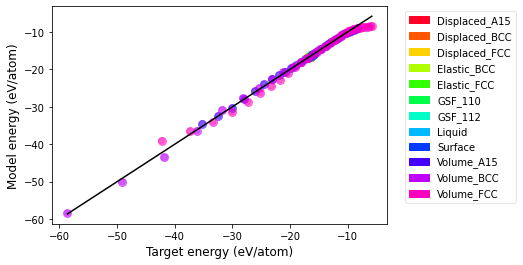

In [ ]:
dataframe_tool.plot_agreement("Energy", fitting_set="Training", mode="Linear")

More plotting options:

Energy MAE: 0.11278674722618177 (eV/atom)


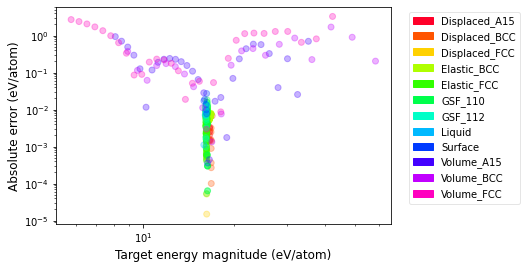

In [ ]:
dataframe_tool.plot_agreement("Energy", fitting_set="Training", mode="Distribution")

Force MAE: 0.07575757670459773 (eV/A)


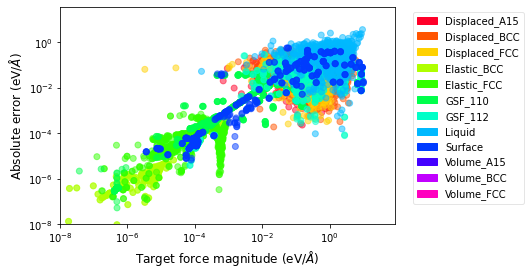

In [ ]:
dataframe_tool.plot_agreement("Force", fitting_set="Training", mode="Distribution")

Aside from the dataframe, FitSNAP also made LAMMPS-ready potential files.

*   `Ta_pot.snapcoeff`
*   `Ta_pot.snapcoeff`



We can use this to run MD or calculate errors on an entirely separate set, without performing fits.

# Use your potential with LAMMPS to test errors on another set

*   When training, we calculate errors on the training set and a validation set.
*   Often it is useful to calculate errors on entirely different set (a "test set") after training.
*   We can use FitSNAP+LAMMPS Python libraries for this.
*   We will load our fitted potential into LAMMPS and calculate energies/forces, then compare to the test set.

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014/

from fitsnap3lib.tools.lammps_tools import LammpsTools

# define pair style, input script, and test directory

pairstyle = """
            pair_style hybrid/overlay zbl 4.0 4.8 snap
            pair_coeff * * zbl 73 73
            pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta
            """
input_script = "Ta-example.in"
test_dir = "Test_Set_Example"

# create LammpsTools object

lmp_tools = LammpsTools(pairstyle, input_script, test_dir)

# calculate errors

errors = lmp_tools.calculate() # creates dictionary of errors

print(f"{'Group':20} {'Energy MAE':3} {'Force MAE':3}")
for group in errors:
    print(f"{group:20} {errors[group]['mae_energy']:.3e} {errors[group]['mae_force']:.3e}")

The FitSNAP library does more than just process fitting data.

We can perform entire fits in library mode, offering a lot of flexibility.

### Perform fit in library mode

This is useful if you want to immediately screen for stability, for example when looping over fits. 

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create a fitsnap object

from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

# scrape configs, process configs, and perform the fit

snap.scrape_configs()
snap.process_configs()
snap.perform_fit()

# data frame is contained in snap.solver

snap.solver.df

/content/FitSNAP/examples/Ta_Linear_JCP2014
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
'decorated_scrape_configs' took 493.49 ms on rank 0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6163 GB
'decorated_process_configs' took 3238.86 ms on rank 0
'decorated_perform_fit' took 39.20 ms on rank 0
'fit_gathe

,0,1,2,3,4,5,6,7,8,9,...,30,truths,preds,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.0,1.008658e+02,2.765341e+00,6.321337e-01,8.199368e+00,-2.929603e+00,1.049882e+00,1.269487e+00,6.478146e+01,-2.659469e+00,...,1.868574e+01,-1.659594e+01,-1.659743e+01,1.000000e+02,Displaced_A15,A15_6.json,Energy,0,False,0
1,0.0,-8.172969e-01,3.207648e-01,-5.779219e-03,-3.005608e+00,-1.819393e-01,-2.868259e-01,-1.936471e-01,1.289477e+01,3.302654e-01,...,-7.650562e-01,1.245040e-01,6.679828e-02,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
2,0.0,4.026217e+00,1.207029e+00,-5.604386e-02,-1.540816e+00,-5.526683e-01,1.539374e-01,4.114150e-01,2.253215e+00,1.812435e-01,...,-7.984083e-01,-1.173625e-02,-1.672144e-01,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
3,0.0,4.987529e+00,-1.543632e-02,3.439166e-01,1.760887e+00,-4.900889e-01,7.320640e-01,4.504972e-01,-8.064445e+00,-1.550447e+00,...,5.464866e+00,2.303159e-01,1.533244e-01,1.000000e+00,Displaced_A15,A15_6.json,Force,0,False,1
4,0.0,1.028963e+00,-1.608898e-02,1.003200e-01,3.614395e+00,-2.185651e-01,2.686247e-01,4.793502e-01,-1.232282e+01,-8.294180e-01,...,6.070528e+00,2.194609e-01,8.180922e-02,1.000000e+00,Displaced_A15,A15_6.json,Force,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15208,0.0,5.176823e+07,-5.637398e+05,-2.279712e+05,-1.793350e+06,1.024775e+06,-1.110472e+05,-6.246316e+05,1.797536e+06,-1.166747e+05,...,-7.151426e+06,-1.571006e+06,-2.100401e+06,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15209,0.0,5.176823e+07,-5.637398e+05,-2.279712e+05,-1.793350e+06,1.024775e+06,-1.110472e+05,-6.246316e+05,1.797536e+06,-1.166747e+05,...,-7.151426e+06,-1.571006e+06,-2.100401e+06,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15210,0.0,-7.676561e-10,-1.199463e-11,1.049530e-11,0.000000e+00,4.797851e-11,-5.247649e-12,-2.998657e-12,-8.396239e-11,2.099060e-11,...,9.595702e-11,7.939559e-12,5.396776e-11,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0
15211,0.0,0.000000e+00,-2.398925e-11,5.997314e-12,0.000000e+00,7.196776e-11,-8.995970e-12,-5.997314e-12,-8.396239e-11,2.099060e-11,...,3.358496e-10,3.196322e-11,1.707722e-11,1.000000e-09,Volume_FCC,FCC_3.9.json,Stress,0,False,0


This creates LAMMPS-ready potential files like running with the executable.

###Run MD in the same python script!

Use our LAMMPS-ready potential files immediately for MD.

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# run MD

import lammps
lmp = lammps.lammps()

lammps_commands=\
"""
# initialize simulation

variable nsteps index 100
variable nrep equal 3
variable a equal 3.316
units           metal

# generate the box and atom positions using a BCC lattice

variable nx equal ${nrep}
variable ny equal ${nrep}
variable nz equal ${nrep}
boundary        p p p
lattice         bcc $a
region          box block 0 ${nx} 0 ${ny} 0 ${nz}
create_box      1 box
create_atoms    1 box
mass 1 180.88

# choose potential

pair_style hybrid/overlay zbl 4.0 4.8 snap
pair_coeff * * zbl 73 73
pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta

# setup output

thermo 100
thermo_style    custom step etotal temp pe
compute PE all pe

# set up NVE run

timestep 0.5e-3
neighbor 1.0 bin
neigh_modify once no every 1 delay 0 check yes

# run MD
velocity all create 300.0 4928459 loop geom
fix 1 all nve
run             ${nsteps}
"""

lmp.commands_string(lammps_commands)

# observe potential energy/stability over a 0.5 ps period

for i in range(10):
    pe = lmp.numpy.extract_compute("PE", 0, 0)
    print(pe)
    lmp.command("run 100")

/content/FitSNAP/examples/Ta_Linear_JCP2014
-638.459744887766
-638.7091594598375
-639.3317884482738
-638.8653515334711
-638.9873856533486
-638.948368519429
-639.0358014214421
-638.7717128027743
-639.1745103007074
-638.9794739892559


***We can perform fits, access to the detailed errors in the dataframe, and run MD to check for stability, all in a single Python script.***

This provides a lot of flexibility/possibility for various training methods.

For example, one could loop over many fits while tweaking hyper-parameters.

### Loop over fits


*   This can be done to optimize hyperparameters for example.
*   Use the `config` object to tweak settings for optimization.
*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   See more on Config files at https://docs.python.org/3/library/configparser.html

Define functions that we'll use for looping over fits:

In [ ]:
import numpy as np

def change_descriptor_hyperparams(config):
    """
    Modify descriptor hyperparams associated with a certain config object.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input settings/hyperparameters to tweak

    Returns
    -------

    config: modified Config object
    """

    # twojmax, wj, and radelem are lists of chars

    config.sections['BISPECTRUM'].twojmax = ['6']
    config.sections['BISPECTRUM'].wj = ['1.0']
    config.sections['BISPECTRUM'].radelem = ['0.5']

    # rcutfac and rfac0 are doubles

    config.sections['BISPECTRUM'].rcutfac = 4.67637
    config.sections['BISPECTRUM'].rfac0 = 0.99363

    # after changing twojmax, need to generate_b_list to adjust all other variables

    config.sections['BISPECTRUM']._generate_b_list()

    return config

def change_weights(config, data):
    """
    Change fitting weights associated with each configuration of atoms.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input setting data

    data: FitSNAP data object
        Holds configuration data, positions, forces, weights, for each configuration of atoms

    Returns
    -------

    config: modified Config object

    data: modified data object
    """

    # loop through all group weights in the group_table and change the value

    for key in config.sections['GROUPS'].group_table:
        for subkey in config.sections['GROUPS'].group_table[key]:
            if ("weight" in subkey):
                # change the weight
                config.sections['GROUPS'].group_table[key][subkey] = np.random.rand(1)[0]

    # loop through all configurations and set a new weight based on the group table

    for i, configuration in enumerate(data):
        group_name = configuration['Group']
        new_weight = config.sections['GROUPS'].group_table[group_name]
        for key in config.sections['GROUPS'].group_table[group_name]:
            if ("weight" in key):
                # set new weight 
                configuration[key] = config.sections['GROUPS'].group_table[group_name][key]

    return(config, data)

Use these functions to loop over fits while changing descriptors settings and/or weights:

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
from fitsnap3lib.fitsnap import FitSnap

ngenerations = 2
for g in range(0,ngenerations):

    # instantiate library objects

    pt = ParallelTools()
    config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
    snap = FitSnap()

    # scrape configs

    snap.scraper.scrape_groups()
    snap.scraper.divvy_up_configs()
    snap.data = snap.scraper.scrape_configs()

    # change the bispectrum hyperparams

    config = change_descriptor_hyperparams(config)

    # change weight hyperparams

    (config, snap.data) = change_weights(config, snap.data)
    
    # process configs with new hyperparams
    # set indices to zero for populating new data array

    snap.calculator.shared_index=0
    snap.calculator.distributed_index=0 
    snap.process_configs()
     
    # perform a fit and gather dataframe with snap.solver.error_analysis()

    snap.solver.perform_fit()
    snap.solver.fit_gather()
    # need to empty errors before doing error analysis
    snap.solver.errors = []
    snap.solver.error_analysis()

    # now we have the dataframe, calculate errors with it

    df_tool = DataframeTools(snap.solver.df)
    mae_energy = df_tool.calc_error("Energy", "Training")
    mae_force = df_tool.calc_error("Force", "Training")

    print(f"---------- Generation {g} Force MAE: {mae_force} Energy MAE: {mae_energy}")

/content/FitSNAP/examples/Ta_Linear_JCP2014
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6163 GB
'decorated_process_configs' took 2730.50 ms on rank 0
---------- Generation 0 Force MAE: 0.2358274514667978 Energy MAE: 0.11792016324133435
Using LAMMPSSNAP as FitS

Can get creative here:

*   Run MD each iteration and train for stability, or some other property.
*   Optimize against some other external validation set, chosen by whatever means.
*   Any optimization approach can be wrapped around this framework.

# Uncertainty Quantification (UQ)

FitSNAP provides UQ for linear models via an analytical Bayesian method, where we calculate covariances for each fitting coefficient in the linear model. This is achieved by declaring `solver = ANL` in the input script. This performs a linear fit like we saw before, but now with covariances for each fitting coefficient in a `covariance.npy` file. We illustrate this using the Ta example again, with the ANL solver.

In [5]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014/anl
!python -m fitsnap3 UQ.in --overwrite

/content/FitSNAP/examples/Ta_Linear_JCP2014/anl
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-03-14 04:43:44.151264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-14 04:43:44.151462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-14 04:43:44.151485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If yo

In [6]:
!ls

covariance.npy					   Ta_metrics.md
Descriptors.npy					   Ta_pot.mod
FitSNAP.df					   Ta_pot.snapcoeff
log.lammps					   Ta_pot.snapparam
making_plots_with_diagonal_plots_plotting_tool.py  Truth-Ref.npy
mean.npy					   UQ.in
plotting_tool.py				   Weights.npy
README.md


Now we use the resulting `covariance.npy` file to make parity plots like we did before, but with uncertainty bars. The following script uses the `FitSNAP.df` to make parity plots with uncertainty for each group in the input script.

In [7]:
!python plotting_tool.py

Visualize an example parity plot for energies in the `Displaced_FCC` group:

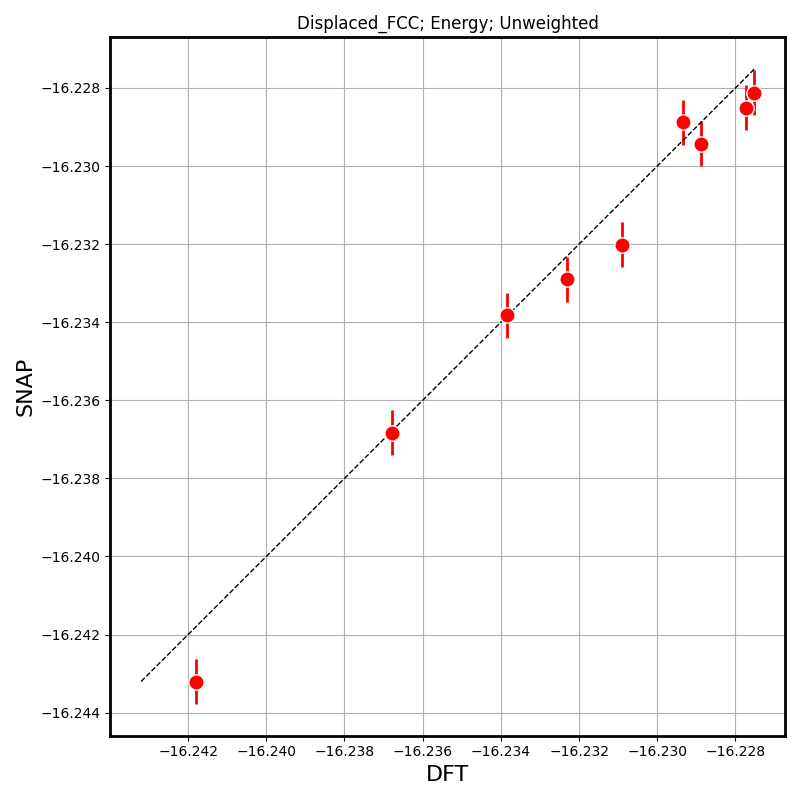

In [8]:
from IPython.display import Image
Image('dm_Displaced_FCC_Energy_Unweighted.png')

*These capabilities demonstrate our basic fitting capabilities for linear models, but what about analyzing the data that we fit to?*

### Extracting per-atom SNAP descriptors

This is useful if you want to inspect the phase space of your descriptors, do PCA analysis to see how similar configurations are, etc.

Make the following changes to the input script: 

*   `bikflag = 1` in `[BISPECTRUM]`
*   `bzeroflag = 1` in `[BISPECTRUM]` (required by `per_atom_energy = 1`)
*   `per_atom_energy = 1` in `[CALCULATOR]`

Calculate per-atom descriptors without performing a fit:

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
!python -m fitsnap3 Ta-example.in --overwrite --nofit

Now our dataframe contains per-atom descriptors (we have more rows than before)


In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()
df

We can use this to visualize how similar certain groups/configurations are to each other. 

E.g. t-SNE analysis (thanks Logan!) 

Takes ~5 min to plot

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import dataframe tools

from fitsnap3lib.tools.dataframe_tools import DataframeTools

# create dataframe tool object

df_tool = DataframeTools("FitSNAP.df")

# read dataframe and plot t-SNE

df = df_tool.read_dataframe()
df_tool.plot_tsne(num_descriptors = 30, point_size=0.2)

We also need per-atom descriptors for NN potentials, which we will do next.

# Fit NN-SNAP with Ta set


*   Look at input script in `/content/FitSNAP/examples/Ta_PyTorch_NN/Ta-example.in`
*   See more on PyTorch models at https://fitsnap.github.io/Pytorch.html



In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

!python -m fitsnap3 Ta-example.in --overwrite

/content/FitSNAP/examples/Ta_PyTorch_NN
----- Global weights set: Overriding group weights.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-03-09 17:59:47.341607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 17:59:47.341836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 17:59:47.341865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: 

Look at loss vs. epochs

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from matplotlib import pyplot as plt
import numpy as np

# matplotlib settings

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# load loss vs. epochs file

dat = np.loadtxt("loss_vs_epochs.dat")

# plot

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

Look at training and validation errors for forces and energies

/content/FitSNAP/examples/Ta_PyTorch_NN
  Force train mae: 0.06796428898952195
  Force train rmse: 0.13437348227439505
  Force test mae: 0.07275032560940997
  Force test rmse: 0.14722132368952356
  Energy train mae: 0.10205394442024379
  Energy train rmse: 0.14046914245088588
  Energy test mae: 0.11218377100636975
  Energy test rmse: 0.16975225168230862


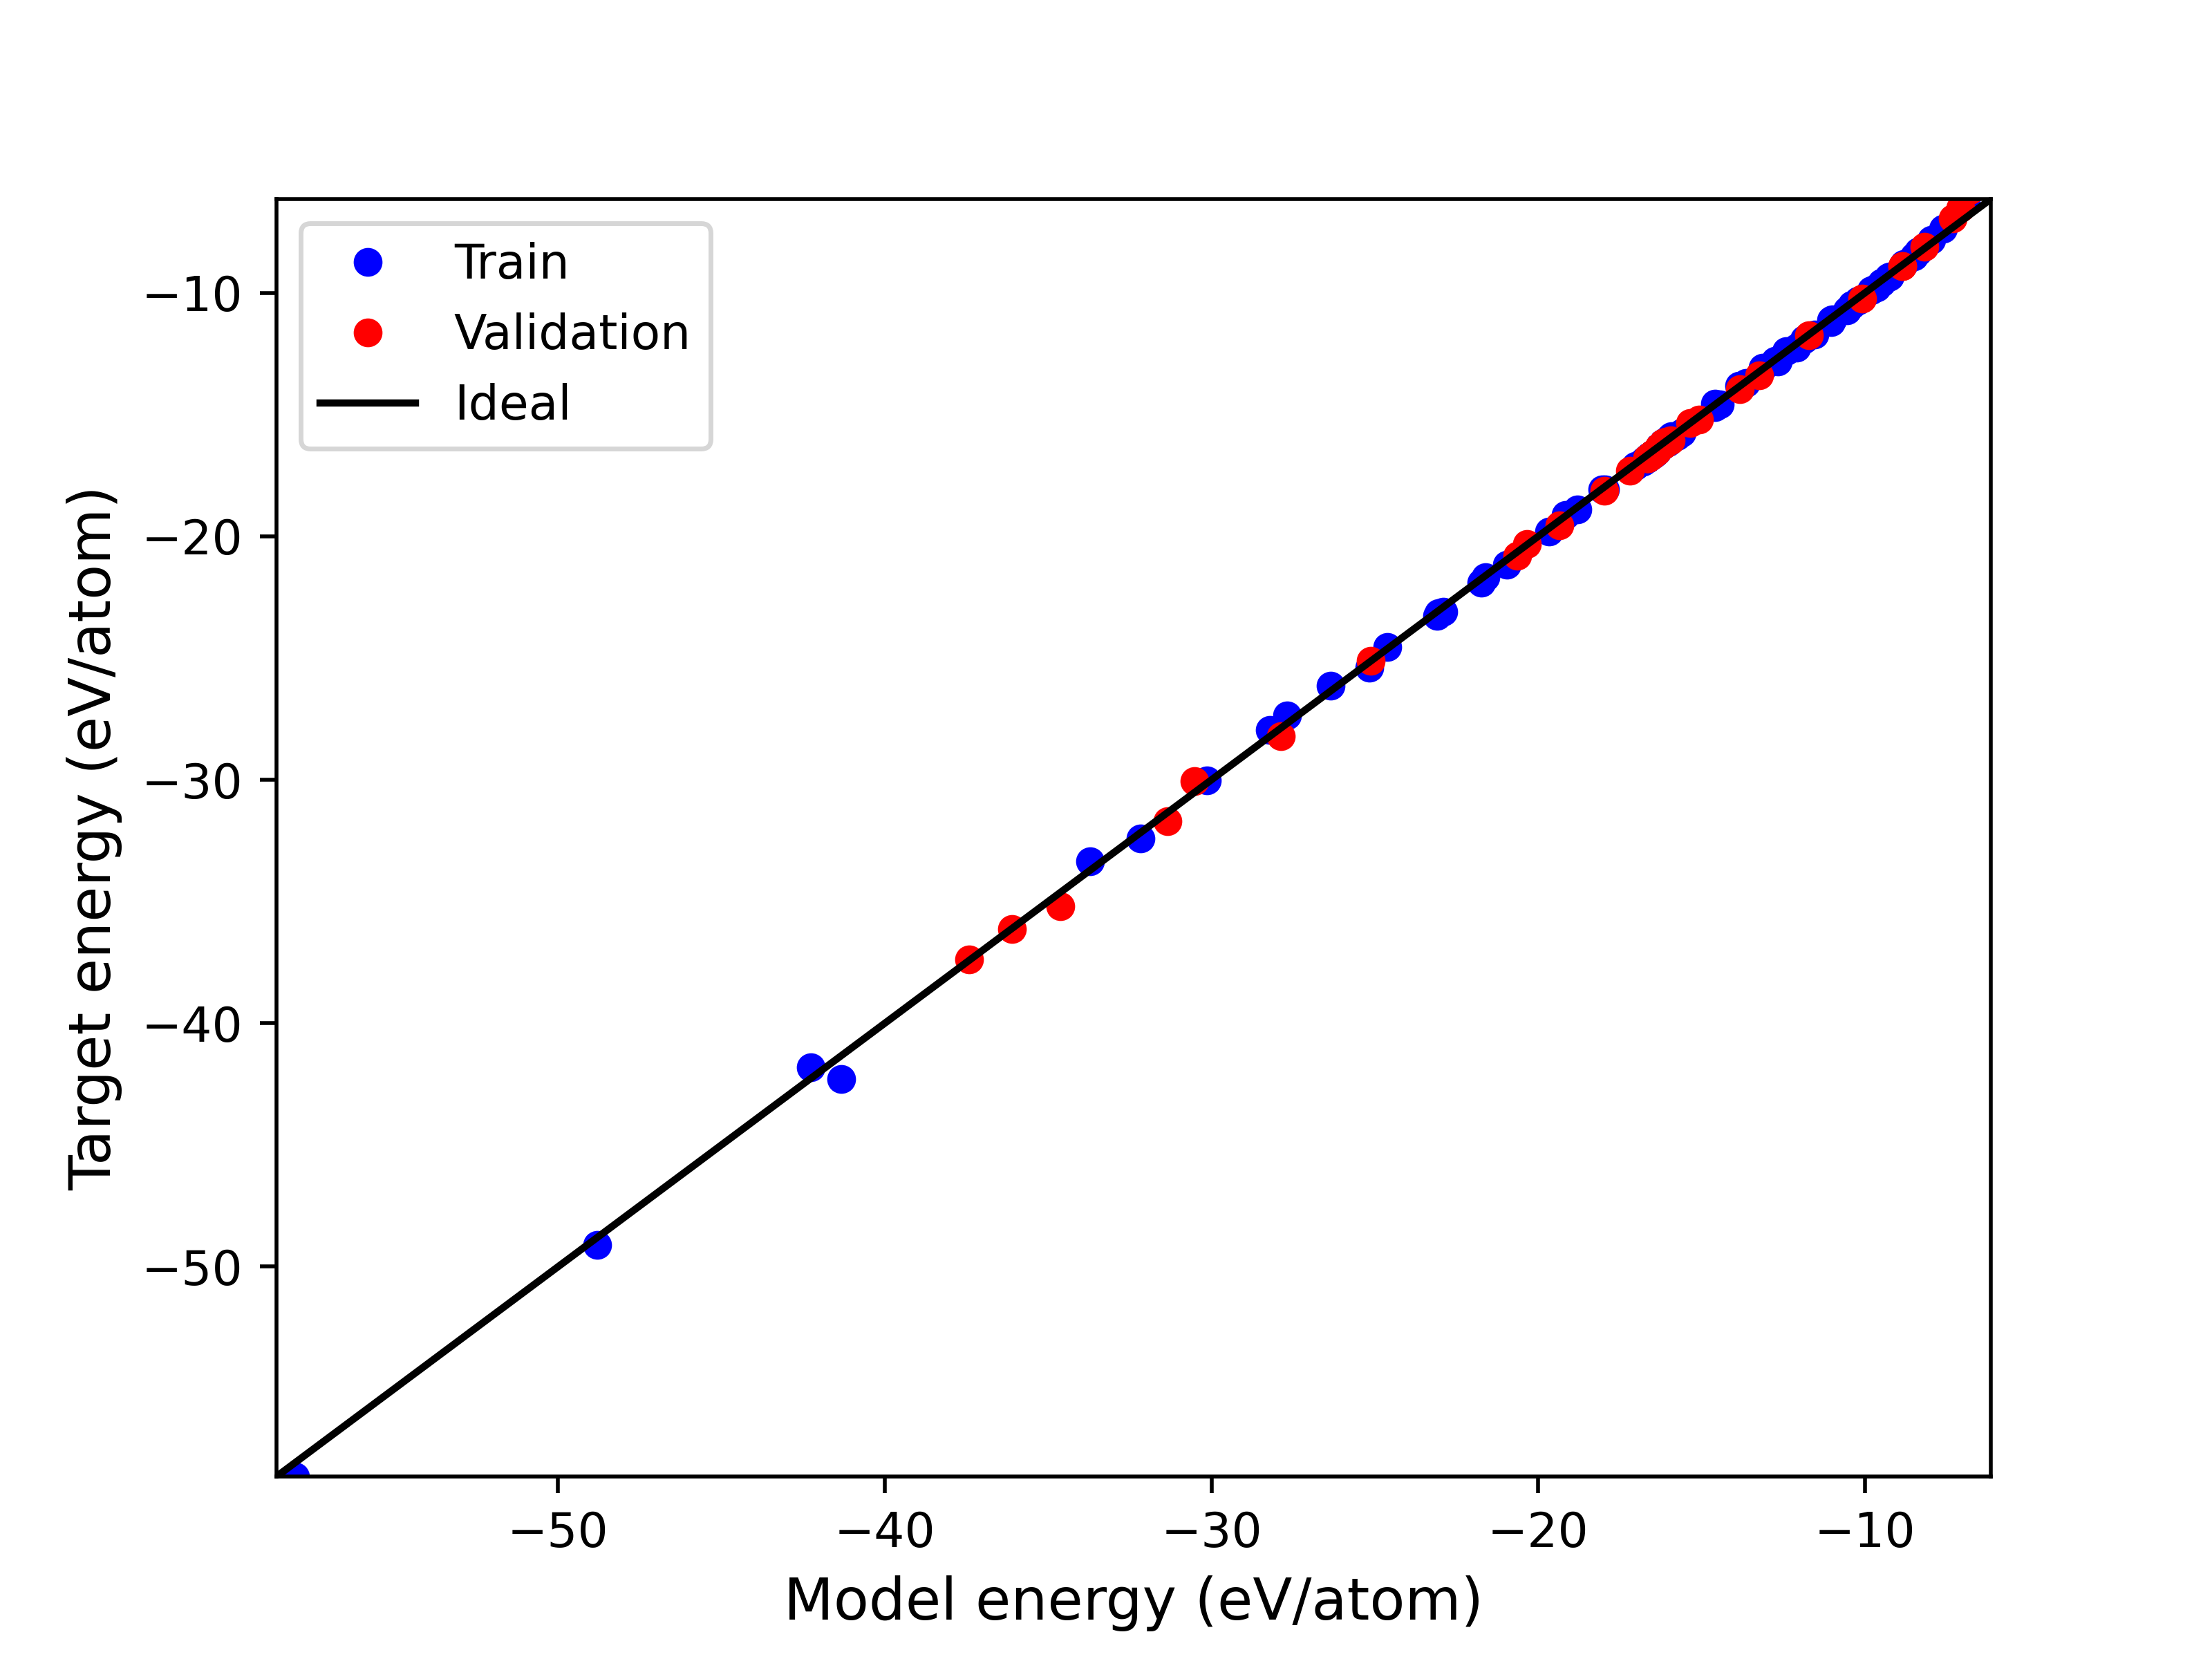

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from IPython.display import Image

!python plot_comparison.py
Image('energy_comparison.png')

/content/FitSNAP/examples/Ta_PyTorch_NN
/bin/bash: plot_comparison.py: command not found


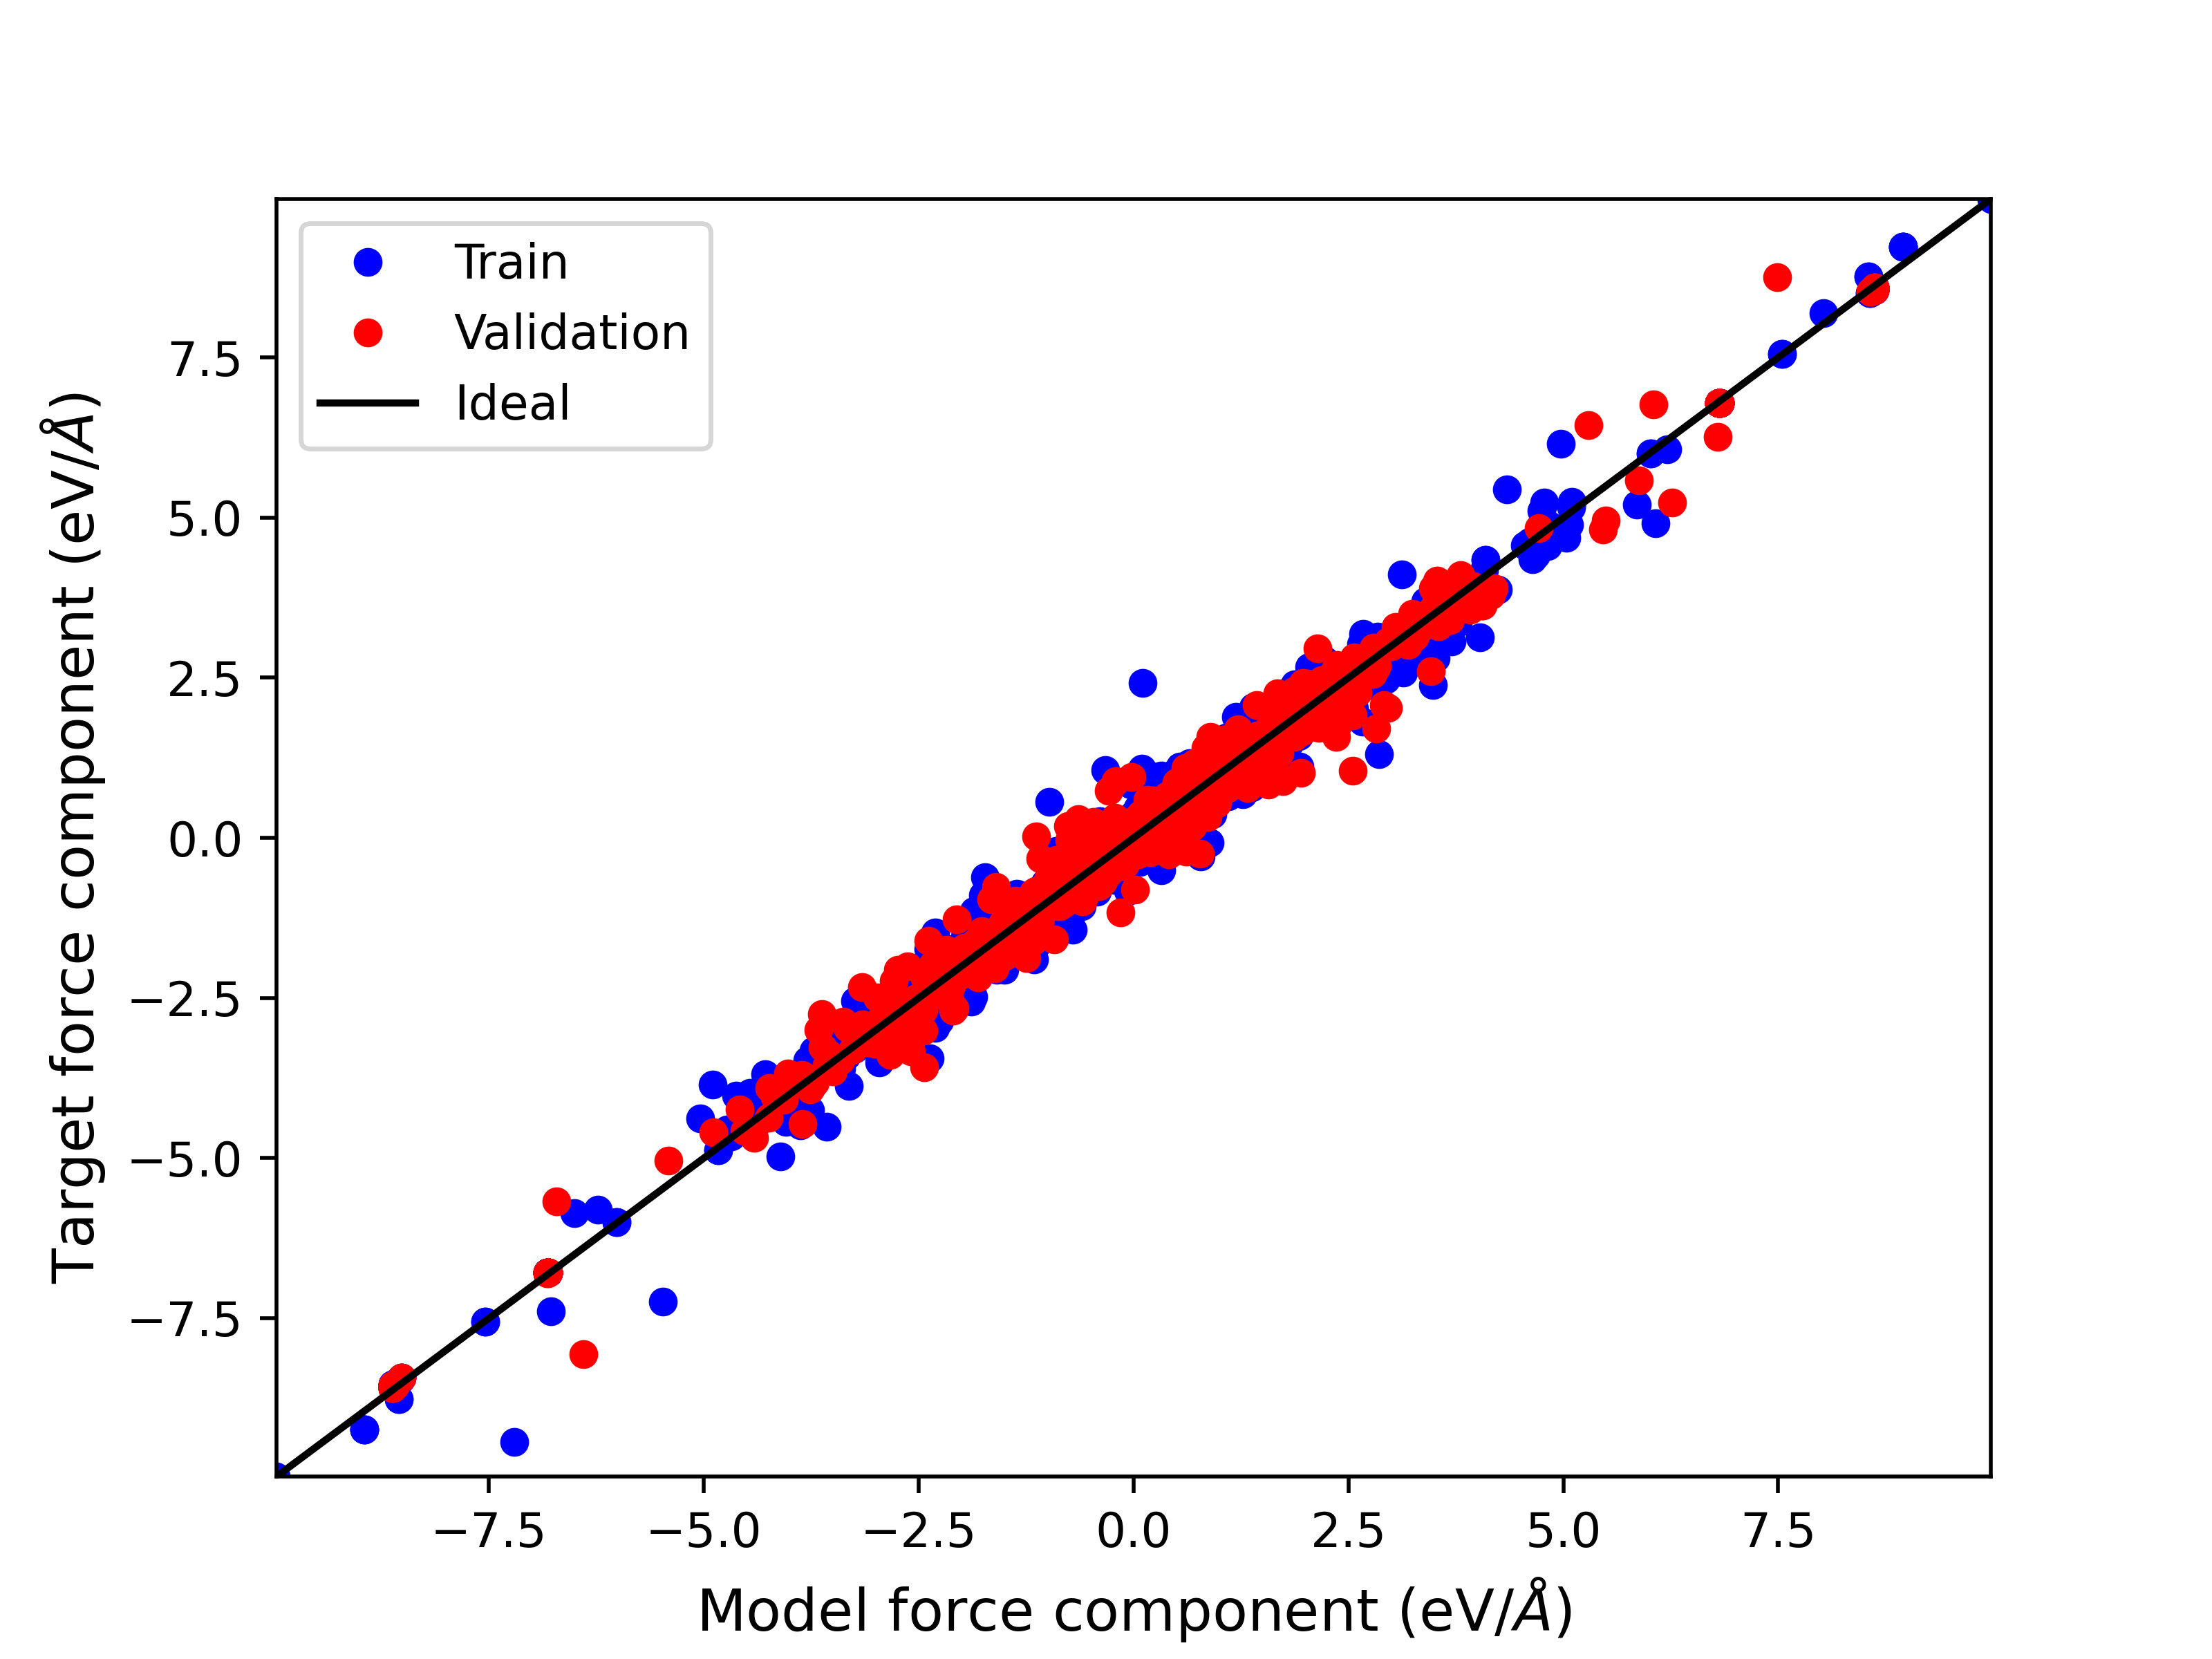

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from IPython.display import Image

!plot_comparison.py
Image('force_comparison.png')

This fit created a LAMMPS-ready PyTorch file for running MD via the ML-IAP package.

In [ ]:
!ls

calculate_fitting_errors.py  MD			      Ta-example.in
energy_comparison.png	     peratom.dat	      Ta_metrics.md
fd_force_check.py	     perconfig.dat	      Ta_pot.mliap.descriptor
FitTorch_Pytorch.pt	     plot_comparison.py       Ta_pot.mod
force_comparison.png	     plot_error_vs_epochs.py  Ta_Pytorch.pt
log.lammps		     RandomSamplingSeed.txt
loss_vs_epochs.dat	     README.md


See the LAMMPS input script in /content/FitSNAP/examples/Ta_PyTorch_NN/MD/in.run

### Run MD with Ta NN-SNAP

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN/MD

!/content/lammps/build/lmp < in.run

/content/FitSNAP/examples/Ta_PyTorch_NN/MD
LAMMPS (8 Feb 2023)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.316 3.316 3.316
Created orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  1 by 1 by 1 MPI processor grid
Created 128 atoms
  using lattice units in orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  create_atoms CPU = 0.000 seconds
Loading python model complete.
SNAP keyword rcutfac 4.67637 
SNAP keyword twojmax 6 
SNAP keyword nelems 1 
SNAP keyword elems Ta 
SNAP keyword radelems 0.5 
SNAP keyword welems 1.0 
SNAP keyword rfac0 0.99363 
SNAP keyword rmin0 0.0 
SNAP keyword switchinnerflag 0 
SNAP keyword bzeroflag 1 
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5.8
  ghost atom cutoff = 5.8
  binsize = 2.9, bins = 5 5 5
  2 neighbor lists, perpetual/occasiona

# Multi-element NNs

Example: Fit to ~1000 configurations in the WBe set.

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

#!mpirun --allow-run-as-root -np 4 python -m fitsnap3 WBe-example.in --overwrite
!python -m fitsnap3 WBe-example.in --overwrite

/content/FitSNAP/examples/WBe_PyTorch_NN
----- manual_seed_flag=1: Setting random seed to 0 for debugging.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-03-09 18:04:45.524541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 18:04:45.524733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 18:04:45.524757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] T

Look at loss vs. epochs:

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

dat = np.loadtxt("loss_vs_epochs.dat")

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

Visualize training and validation errors for energies:

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

from IPython.display import Image

!python plot_comparison.py
Image('energy_comparison.png')

For forces:

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

Image('force_comparison.png')

We also created a `FitTorch_pytorch.pt` file which is used by LAMMPS for MD.

### Run MD with WBe NN-SNAP

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN/MD

!/content/lammps/build/lmp < in.run

/content/FitSNAP/examples/WBe_PyTorch_NN/MD
LAMMPS (8 Feb 2023)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.1803 3.1803 3.1803
Created orthogonal box = (0 0 0) to (12.7212 12.7212 12.7212)
  1 by 1 by 1 MPI processor grid
Created 128 atoms
  using lattice units in orthogonal box = (0 0 0) to (12.7212 12.7212 12.7212)
  create_atoms CPU = 0.000 seconds
Setting atom values ...
  3 settings made for type/fraction
125 atoms in group tungsten
3 atoms in group beryllium
Loading python model complete.
SNAP keyword rcutfac 4.812302818 
SNAP keyword twojmax 6 
SNAP keyword nelems 2 
SNAP keyword elems W Be 
SNAP keyword radelems 0.5 0.417932464 
SNAP keyword welems 1.0 0.9590493408 
SNAP keyword rfac0 0.99363 
SNAP keyword rmin0 0.0 
SNAP keyword switchinnerflag 0 
SNAP keyword bzeroflag 1 
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom:

# NN training computational benchmarks

Training computation scales roughly as `num_atoms*num_neighs`.

Rough benchmarks for CPU training:

*   Ta example - 363 configs, ~12 atoms per config, batch_size=4: 0.3 s/epoch
*   WBe example - ~5000 configs, ~24 atoms per config, batch_size=4: 13 s/epoch
*   W entropy dataset - 10k configs, ~30 atoms per config, batch_size=4: 22 s/epoch
*   Svetoslav set - 42k configs, ~40 atoms per config, batch_size=4, ***cutoff = 15 A***: 5 min/epoch

### GPU acceleration

If you have a GPU with CUDA and PyTorch installed, the NN training will automatically use it. 

There is one way to observe GPU speedups: give it a lot of operations to parallelize over. 

This is achieved with:

1.   Large batch size
2.   Large model size

Our examples used neither, but we are free to experiment here, and optimize settings for performance.





# Advanced/Development Topics: Custom Calculator

We can extract pure LAMMPS positions and neighlist.

This allows one to define their own descriptor and Solver using these positions.

This opens up many possibilities when combined with differentiable programming.

See more on adding your own calculator and solver at: https://fitsnap.github.io/Executable.html


# End-to-End Differentiable Potential Optimization


Pros: 

*   "Descriptor" hyperparams get optimized as a part of the computational graph.

Cons:

*   Slower training, need to evaluate descriptors every epoch (might be worth it considering no descriptor hyperparameters).

# Pairwise networks

For this example we will use Bessel function descriptors located in `fitsnap3lib/lib/neural_networks/descriptors/bessel.py`


Advantages:

*   General atom-type description allows extension to many atom types.
*   More granularity in interactions (pairwise vs. per-atom) might allow for more flexibility and increased accuracy.



**First thing to check with custom models is that analytical/autograd forces equal finite difference forces:**

This performs many finite difference calculations and compared finite difference forces to analytical/autodiff forces.

(~10 min to run on Colab)

/content/FitSNAP/examples/Ta_pytorch_custom_NN
----- Global weights set: Overriding group weights.
Using LAMMPSCUSTOM as FitSNAP calculator
Pytorch device is set to cpu
Displaced_BCC : Detected  9  fitting on  9  testing on  0
'decorated_scrape_configs' took 48.57 ms on rank 0
Nonlinear solver, preprocessing configs.
>>> Matrix of data takes up  0.0015 % of the total memory: 13.6163 GB
'decorated_process_configs' took 2653.25 ms on rank 0
Nonlinear solver, preprocessing configs.
>>> Matrix of data takes up  0.0015 % of the total memory: 13.6163 GB
'decorated_process_configs' took 292.53 ms on rank 0
Nonlinear solver, preprocessing configs.
>>> Matrix of data takes up  0.0015 % of the total memory: 13.6163 GB
'decorated_process_configs' took 293.00 ms on rank 0
Nonlinear solver, preprocessing configs.
>>> Matrix of data takes up  0.0015 % of the total memory: 13.6163 GB
'decorated_process_configs' took 290.09 ms on rank 0
Nonlinear solver, preprocessing configs.
>>> Matrix of data takes

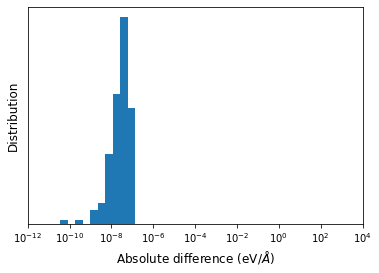

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/

from fitsnap3lib.tools.test_tools import TestTools
from fitsnap3lib.io.input import Config
input_script = "Ta-example.in"
test_tool = TestTools(input_script)
test_tool.finite_difference(group="Displaced_BCC")

Now that we verified forces are correctly coded, we can fit the pairwise network. Run for more epochs to get better fits; we recommend 100-1000 epochs. This shorter fit is appropriate for tutorial purposes.

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/

!python -m fitsnap3 Ta-example.in --overwrite

/content/FitSNAP/examples/Ta_pytorch_custom_NN
----- Global weights set: Overriding group weights.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-03-09 18:19:11.706587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 18:19:11.706731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
2023-03-09 18:19:11.706752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Wa

Visualize agreement in forces:

/content/FitSNAP/examples/Ta_pytorch_custom_NN


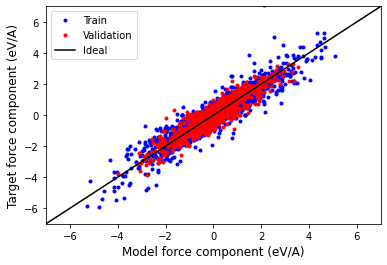

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/
import matplotlib.pyplot as plt

dat = np.loadtxt("force_comparison.dat")
dat_val = np.loadtxt("force_comparison_val.dat")

lims = [-7, 7]
plt.plot(dat[:,0], dat[:,1], 'bo', markersize=3)
plt.plot(dat_val[:,0], dat_val[:,1], 'ro', markersize=3)
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model force component (eV/A)")
plt.ylabel("Target force component (eV/A)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show() 